In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import os
import codecs

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sns.set(style='ticks', context='poster')

E:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_directory = os.path.join('..', 'data')
crypto_filepath = os.path.join(data_directory, 'crypto-markets.csv')
crypto_filepath

'..\\data\\crypto-markets.csv'

The majority of this notebook is preprocessing.

In [3]:
crypto = pd.read_csv(crypto_filepath)
crypto.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30000,135.98000,132.10000,134.21000,0,1500520000,0.54380,3.88000
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44000,147.49000,134.00000,144.54000,0,1491160000,0.78130,13.49000
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00000,146.93000,134.05000,139.00000,0,1597780000,0.38430,12.88000
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00000,139.89000,107.72000,116.99000,0,1542820000,0.28820,32.17000
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38000,125.60000,92.28000,105.21000,0,1292190000,0.38810,33.32000


In [4]:
# eth.isnull() -> boolean same size array indicating if value is either null (objects) or NaN (numeric)
crypto.isnull().any()

slug           False
symbol         False
name           False
date           False
ranknow        False
open           False
high           False
low            False
close          False
volume         False
market         False
close_ratio     True
spread         False
dtype: bool

The close_ratio has null values 

In [5]:
crypto.drop(['close_ratio'], axis=1, inplace=True)

In [6]:
crypto['ohlc_average'] = (crypto['open'] + crypto['high'] + crypto['low'] + crypto['close']) / 4

In [7]:
crypto['date'] = pd.to_datetime(crypto['date'], format='%Y-%m-%d')
crypto.set_index('date')
crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659373 entries, 0 to 659372
Data columns (total 13 columns):
slug            659373 non-null object
symbol          659373 non-null object
name            659373 non-null object
date            659373 non-null datetime64[ns]
ranknow         659373 non-null int64
open            659373 non-null float64
high            659373 non-null float64
low             659373 non-null float64
close           659373 non-null float64
volume          659373 non-null int64
market          659373 non-null int64
spread          659373 non-null float64
ohlc_average    659373 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 57.9+ MB


In [8]:
eth = crypto[crypto['symbol']=='ETH']
eth.set_index('date', inplace=True)
eth.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,spread,ohlc_average
date,,,,,,,,,,,,
2015-08-07,ethereum,ETH,Ethereum,2,2.83000,3.54000,2.52000,2.77000,164329,0,1.02000,2.91500
2015-08-08,ethereum,ETH,Ethereum,2,2.79000,2.80000,0.71473,0.75333,674188,167911000,2.09000,1.76451
2015-08-09,ethereum,ETH,Ethereum,2,0.70614,0.87981,0.62919,0.70190,532170,42637600,0.25000,0.72926
2015-08-10,ethereum,ETH,Ethereum,2,0.71399,0.72985,0.63655,0.70845,405283,43130000,0.09000,0.69721
2015-08-11,ethereum,ETH,Ethereum,2,0.70809,1.13000,0.66324,1.07000,1463100,42796500,0.47000,0.89283


In [9]:
# eth_numeric: df with only numeric values of eth
eth_numeric = eth.select_dtypes(include=[np.number])
eth_numeric.head()

,ranknow,open,high,low,close,volume,market,spread,ohlc_average
date,,,,,,,,,
2015-08-07,2,2.83000,3.54000,2.52000,2.77000,164329,0,1.02000,2.91500
2015-08-08,2,2.79000,2.80000,0.71473,0.75333,674188,167911000,2.09000,1.76451
2015-08-09,2,0.70614,0.87981,0.62919,0.70190,532170,42637600,0.25000,0.72926
2015-08-10,2,0.71399,0.72985,0.63655,0.70845,405283,43130000,0.09000,0.69721
2015-08-11,2,0.70809,1.13000,0.66324,1.07000,1463100,42796500,0.47000,0.89283


In [10]:
# Find which numeric columns have zeros
def has_zero(eth_numeric):
    for col in eth_numeric:
        if 0 in eth_numeric[col].values:
            print(col," has a 0")
has_zero(eth_numeric)

market  has a 0


In [11]:
for i, val in eth_numeric.market.iteritems():
    if val == 0:
        print(i," ",val)

2015-08-07 00:00:00   0


In [12]:
eth = eth.loc['2015-08-08':]
eth.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,spread,ohlc_average
date,,,,,,,,,,,,
2015-08-08,ethereum,ETH,Ethereum,2,2.79000,2.80000,0.71473,0.75333,674188,167911000,2.09000,1.76451
2015-08-09,ethereum,ETH,Ethereum,2,0.70614,0.87981,0.62919,0.70190,532170,42637600,0.25000,0.72926
2015-08-10,ethereum,ETH,Ethereum,2,0.71399,0.72985,0.63655,0.70845,405283,43130000,0.09000,0.69721
2015-08-11,ethereum,ETH,Ethereum,2,0.70809,1.13000,0.66324,1.07000,1463100,42796500,0.47000,0.89283
2015-08-12,ethereum,ETH,Ethereum,2,1.06000,1.29000,0.88361,1.22000,2150620,64018400,0.41000,1.11340


As the behavior of the price of eth was was extremely slow until early feburary, it makes sense for us to cut out the data before that time if we want to make predictions for the future.

In [13]:
eth_price_series = eth.ohlc_average
# Cut out the period of little growth before early feb
eth_price_series = eth_price_series["2017-02-04":]

In [14]:
# This code snippit generates a Time Series Plot, a Histogram of our data, an ACF plot, and a PACF plot.

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x3864530>,
 <matplotlib.axes._subplots.AxesSubplot at 0xecc43f0>)

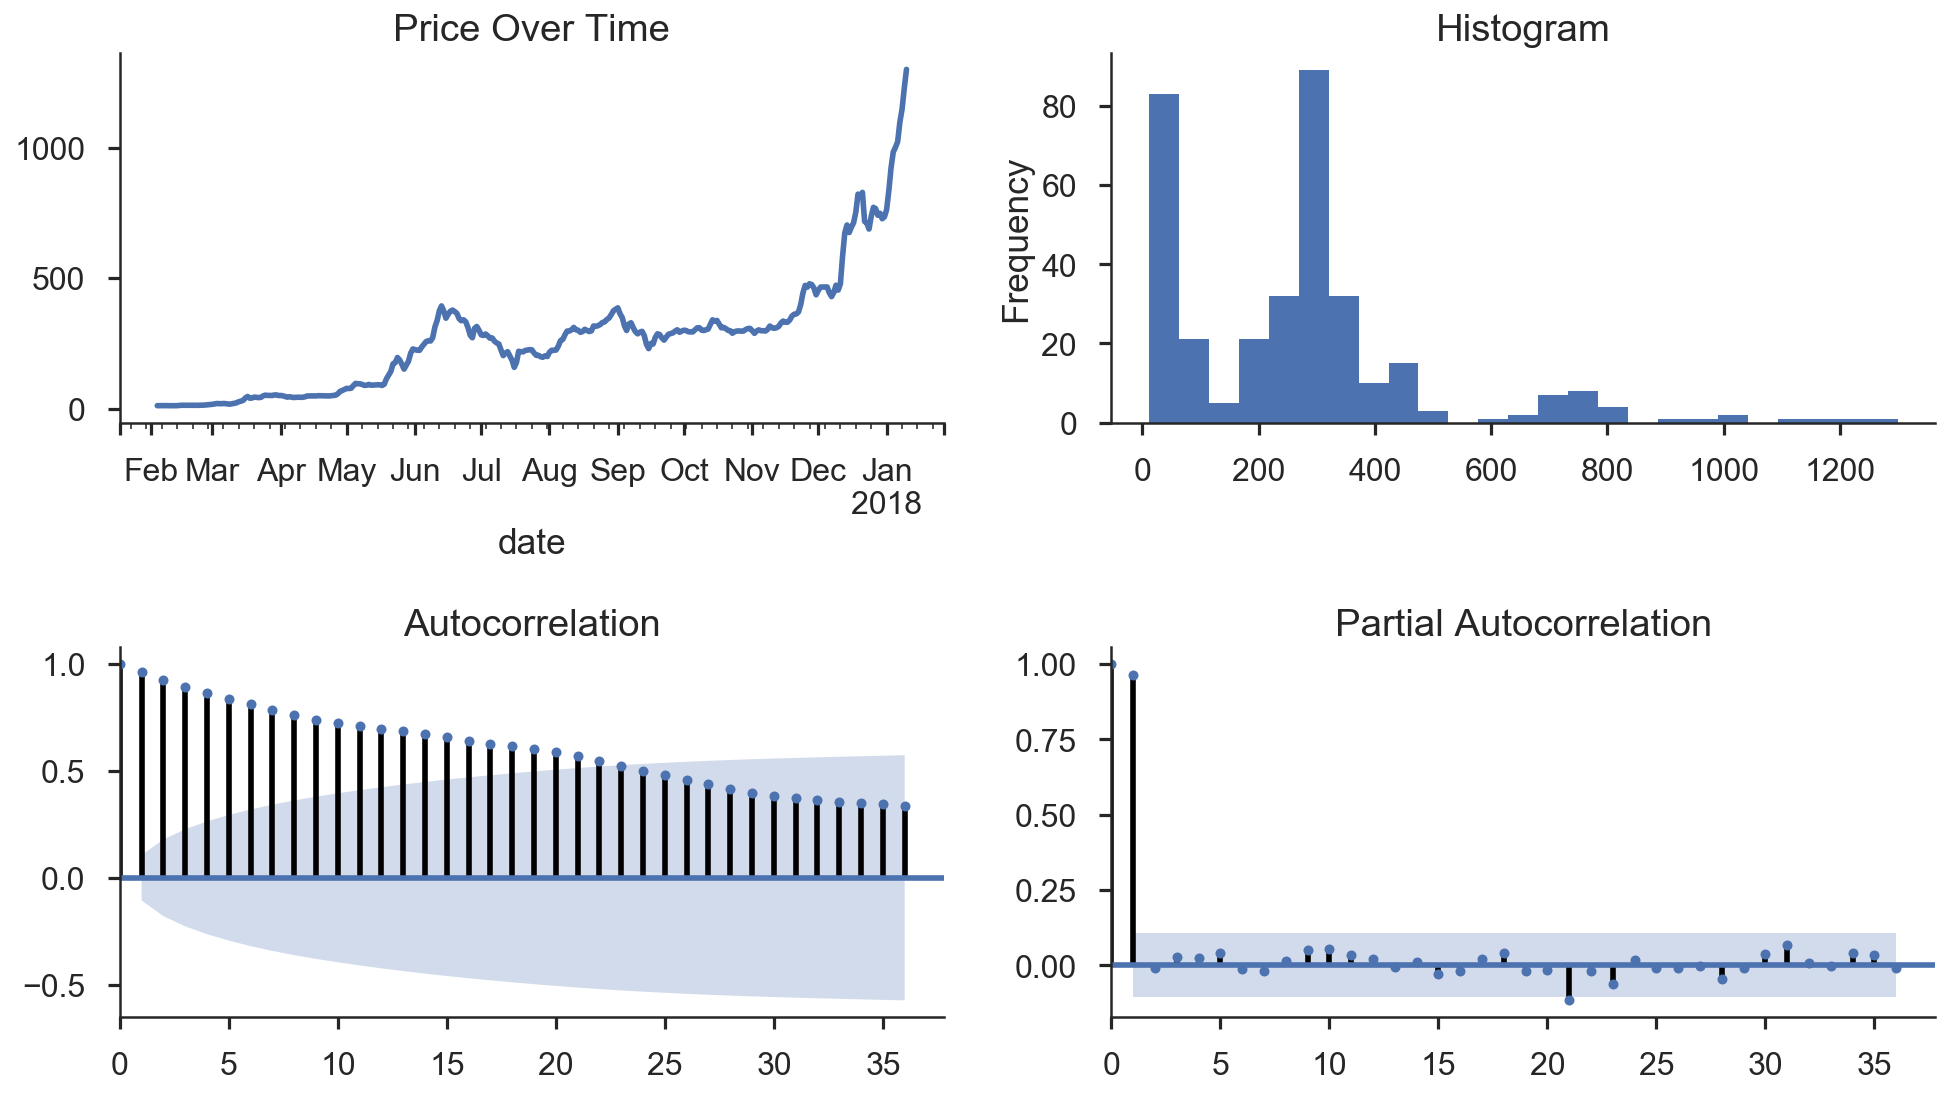

In [15]:
tsplot(eth_price_series, title='Price Over Time', lags=36)

The PACF plot shows a strong autocorrelation of the time series with itself lagged by one day. However this is not meaningful as all this means is that the price of ETH rose consistenly with time which we can tell just from the time series plot. Therefore, we must detrend our data.

# Detrending our data

We can try to detrend our data through differencing (to ensure a stationary mean) and log transforming it (to ensure a stationary variance).

In [16]:
eth_price_series_diff = eth_price_series - eth_price_series.shift()

In [17]:
eth_price_series_diff.dropna(inplace = True)
eth_price_series_diff.head()

date
2017-02-05    0.10250
2017-02-06   -0.01000
2017-02-07    0.10250
2017-02-08   -0.03250
2017-02-09   -0.27500
Name: ohlc_average, dtype: float64

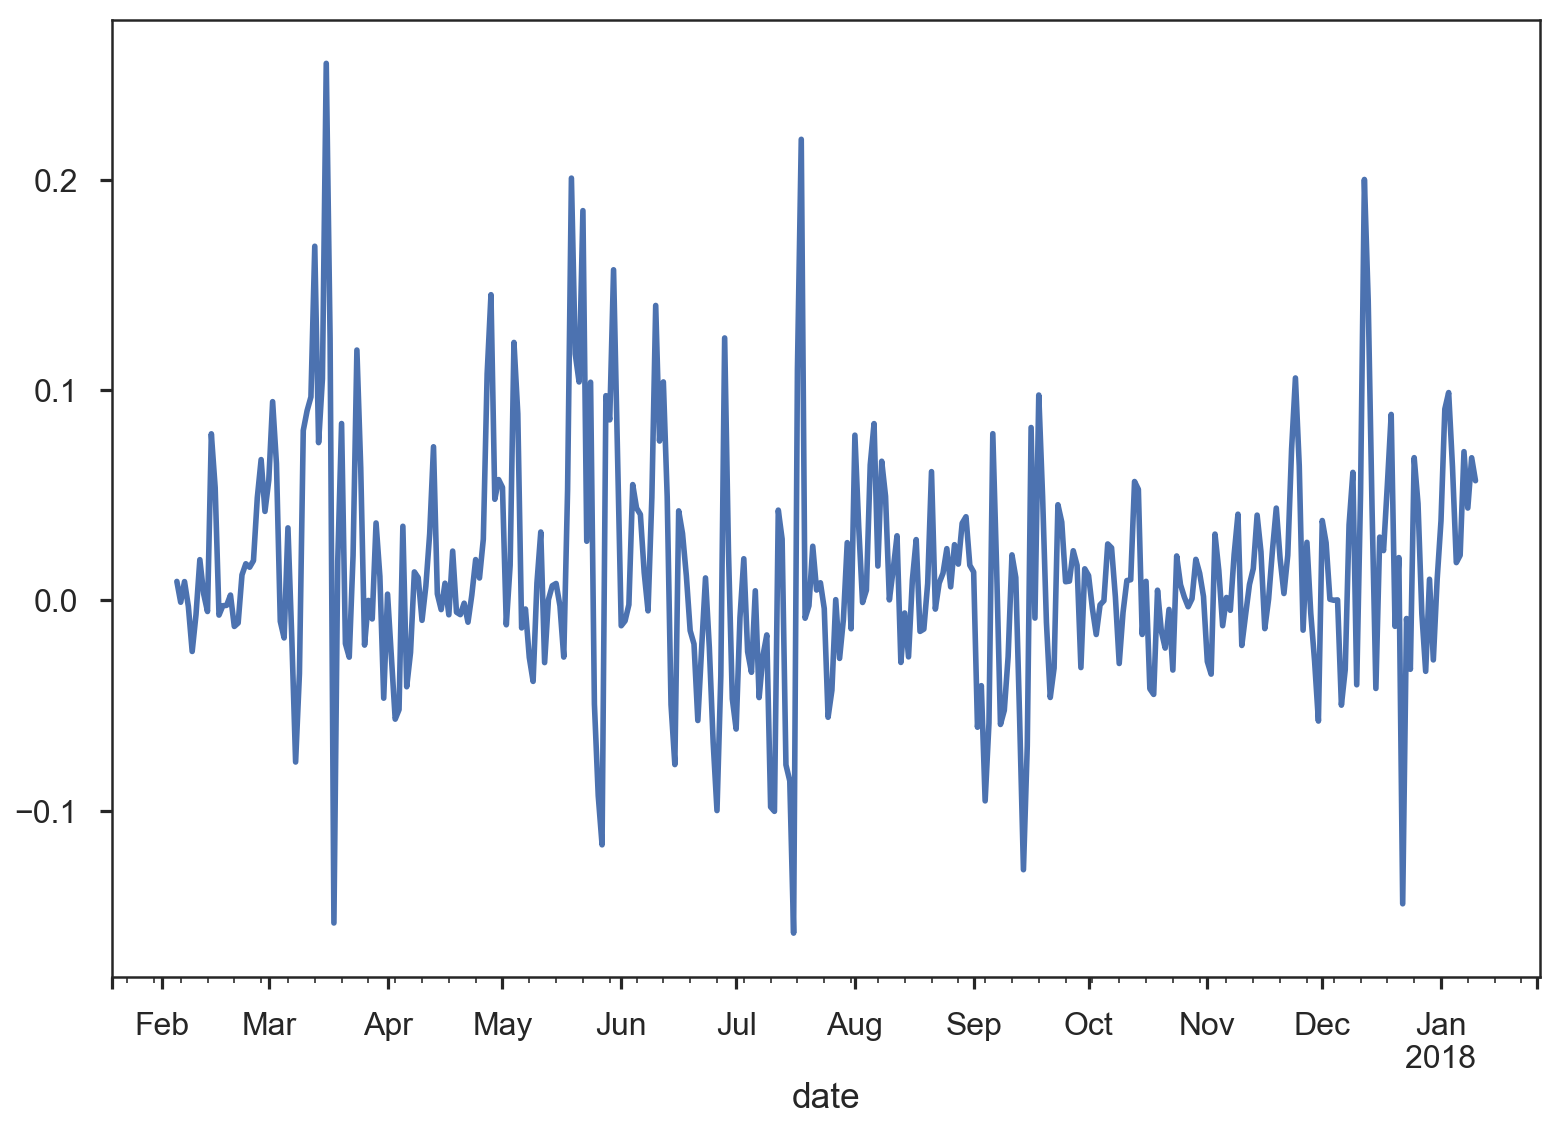

In [18]:
eth_price_series_log = np.log(eth_price_series)
eth_price_diff_log = eth_price_series_log - eth_price_series_log.shift()
eth_price_diff_log.plot()

In [19]:
eth_price_diff_log.dropna(inplace = True)
eth_price_diff_log.head()

date
2017-02-05    0.00903
2017-02-06   -0.00088
2017-02-07    0.00896
2017-02-08   -0.00283
2017-02-09   -0.02429
Name: ohlc_average, dtype: float64

(<matplotlib.axes._subplots.AxesSubplot at 0x1062a6f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x106c99f0>)

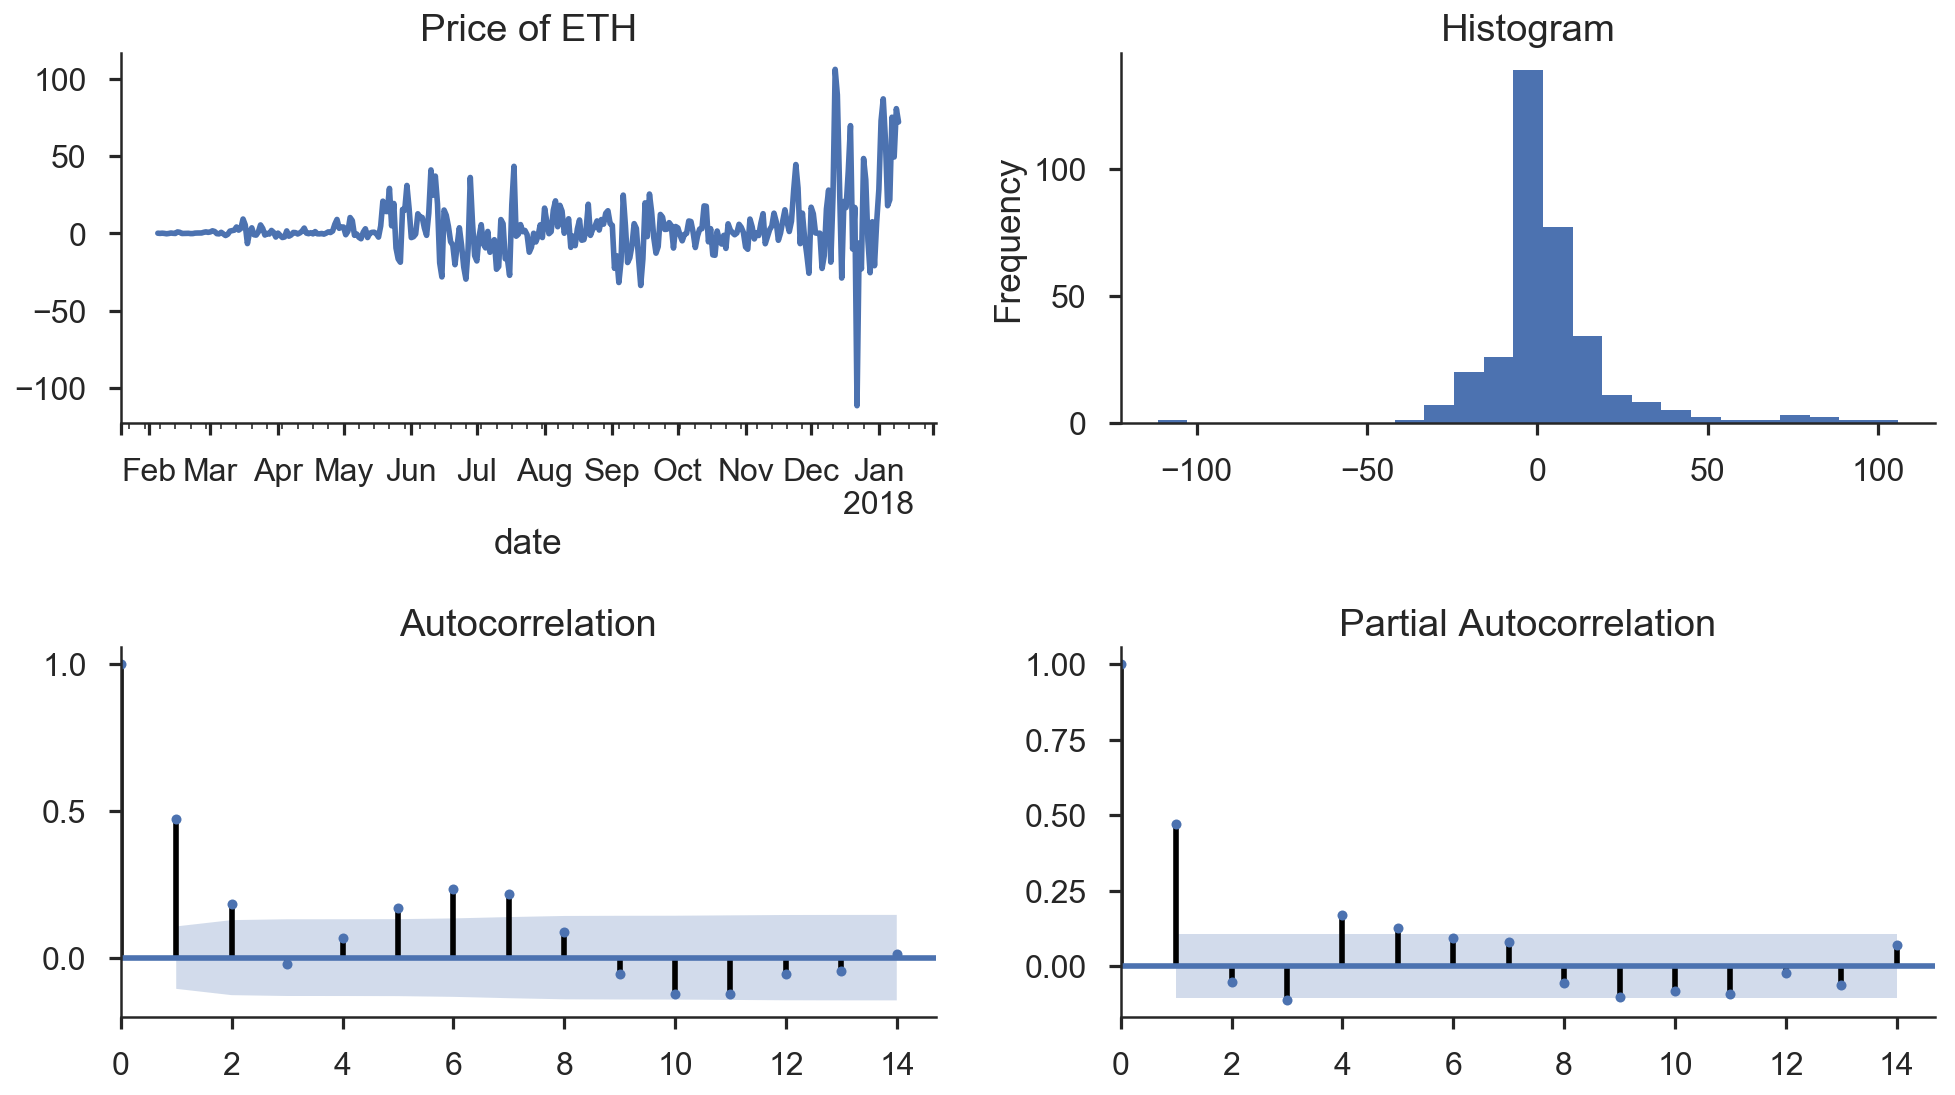

In [20]:
tsplot(eth_price_series_diff, title='Price of ETH', lags=14)

# Model Identification (Trying to find ARIMA model parameters)


- The sample autocorrelation seems to gradually tail off.
- The sample partial autocorrelation seems to cut off fairly sharply at lag 1.
- Based on this, we could try an ARIMA (1, 1, 1) model. 

In [ ]:
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

In [22]:
from statsmodels.tsa.stattools import adfuller
adfuller(eth_price_diff_log.values, autolag = 'AIC', regression = 'ct')

(-8.94874376325939,
 4.740398668716999e-13,
 2,
 337,
 {'1%': -3.9858876182413634,
  '10%': -3.134757548798489,
  '5%': -3.423598642683739},
 -1007.4696478818482)